In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
from sklearn.metrics import confusion_matrix
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE
import joblib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [2]:
# Configuration
MODEL_PATH = 'final_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/final_feature_matrix_gc_corrected_50000.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [3]:
model = joblib.load(MODEL_PATH)

model_step = model.named_steps['stable_model']
c_wert = model_step.C
print(f"Der verwendete C-Wert ist: {c_wert}")


Der verwendete C-Wert ist: 0.8685113737513525


In [4]:
print("Modell Struktur:")
print(model)

model_step = model.named_steps['stable_model']

print("\n--- Modell Parameter ---")
print(f"Gewählter C-Wert (c_1se): {model_step.C}")
print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
print(f"Solver:                  {model_step.solver}")

n_features = np.sum(model_step.coef_ != 0)
model_features = joblib.load('model_features.joblib')
print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")

needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

Modell Struktur:
Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=0.0, keep_empty_features=True,
                               strategy='constant')),
                ('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=0.8685113737513525, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

--- Modell Parameter ---
Gewählter C-Wert (c_1se): 0.8685113737513525
Penalty (Lasso/Ridge):   l1
Solver:                  liblinear
Anzahl relevanter Bins:  105 von 8520
Metrics required by model: ['stdev', 'mean']


In [5]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")
df_holdout = df_holdout[~df_holdout["group"].isin(["duodenal", "esophageal"])]


Loading holdout matrix...


In [6]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (27, 8520)


In [7]:
import joblib
import pandas as pd


train_features = model.feature_names_in_  # sklearn speichert das oft automatisch

holdout_features = X_holdout.columns

missing = set(train_features) - set(holdout_features)
print("Missing in holdout:", len(missing), "of", len(train_features),
      "=", len(missing)/len(train_features))


Missing in holdout: 0 of 8520 = 0.0


In [8]:
missing = set(model_features) - set(X_holdout.columns)
print(len(missing))


0


In [9]:
import numpy as np
import pandas as pd

scaler = model.named_steps["scaler"]

# Z-Scores des Holdouts relativ zur Trainingsverteilung
Z = (X_holdout.values - scaler.mean_) / scaler.scale_

# 1) Wie extrem ist Holdout insgesamt?
absZ = np.abs(Z)
print("max |z|:", np.nanmax(absZ))
print("percentiles |z|:", np.nanpercentile(absZ, [50, 90, 95, 99, 99.9]))

# 2) Welche Features sind am stärksten "off"?
max_absZ_per_feature = np.nanmax(absZ, axis=0)
top_idx = np.argsort(max_absZ_per_feature)[::-1][:20]

top_shift = pd.Series(max_absZ_per_feature[top_idx], index=X_holdout.columns[top_idx])
display(top_shift)

# 3) Wie viele Werte sind extrem außerhalb?
print("fraction |z|>5:", np.nanmean(absZ > 5))
print("fraction |z|>10:", np.nanmean(absZ > 10))


max |z|: 46.29875345678285
percentiles |z|: [ 0.80104454  7.25525341  9.29201936 13.22762475 18.68119   ]


mean_chr2_20650000      46.298753
mean_chr9_124450000     43.325404
mean_chr7_150000        42.528426
mean_chr4_3200000       42.229796
mean_chr8_144300000     40.869821
mean_chr5_1150000       39.875418
mean_chr16_74400000     38.679678
mean_chr21_46150000     38.414177
mean_chr11_1550000      37.805461
mean_chr17_18600000     37.739693
mean_chr2_240850000     37.348784
mean_chr17_81100000     37.224762
mean_chr16_2000000      37.047560
mean_chr9_96900000      36.691201
mean_chr9_131250000     36.370965
mean_chr9_137050000     36.078897
mean_chr7_1650000       35.822209
mean_chr1_2500000       35.264532
mean_chr16_49850000     35.034524
mean_chr10_132350000    34.387037
dtype: float64

fraction |z|>5: 0.15436445835506868
fraction |z|>10: 0.03768040340810294


In [16]:
# feat = "median_chr1_144150000"

# print("Train mean:", scaler.mean_[X_holdout.columns.get_loc(feat)])
# print("Train std:", scaler.scale_[X_holdout.columns.get_loc(feat)])

# print("Holdout mean:", X_holdout[feat].mean())
# print("Holdout min/max:", X_holdout[feat].min(), X_holdout[feat].max())


In [10]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


No NaNs in dataframe
Training Proben erfolgreich geladen: 158


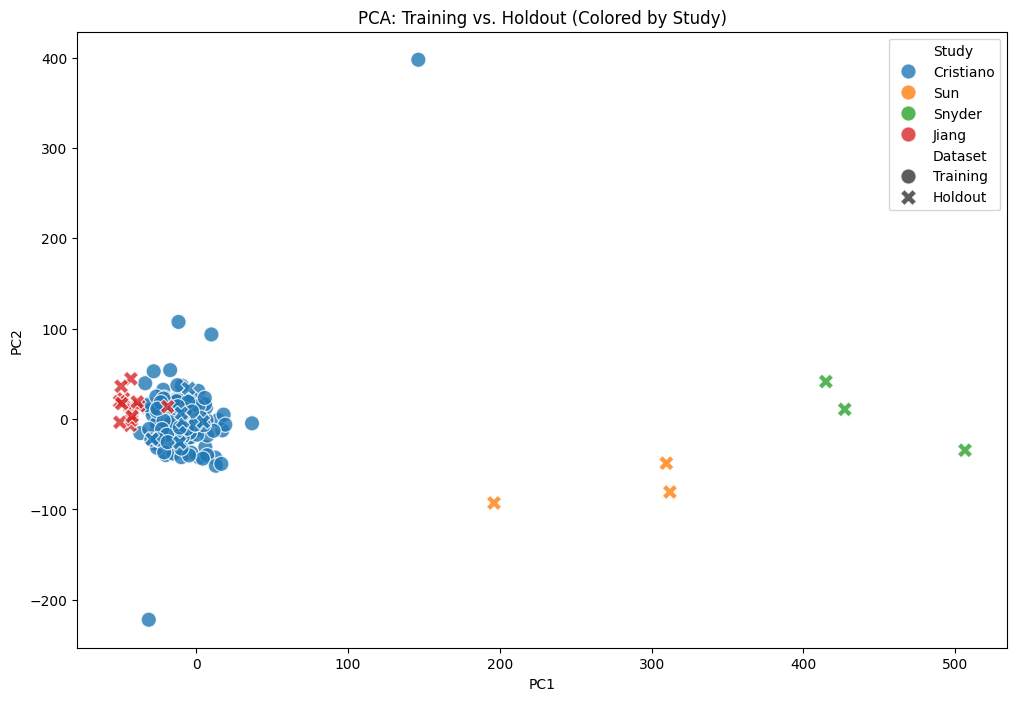

The 5 most extreme samples on PC1:


,PC1,PC2,Patient Type,Study,Dataset
sample,,,,,
EE86244,506.440692,-34.502410,Pancreatic Cancer,Snyder,Holdout
EE86247,427.250299,10.755025,Pancreatic Cancer,Snyder,Holdout
EE86248,414.828034,41.490518,Pancreatic Cancer,Snyder,Holdout
EE85723,312.096227,-80.705293,Colorectal Cancer,Sun,Holdout
EE85724,309.714468,-48.840359,Colorectal Cancer,Sun,Holdout


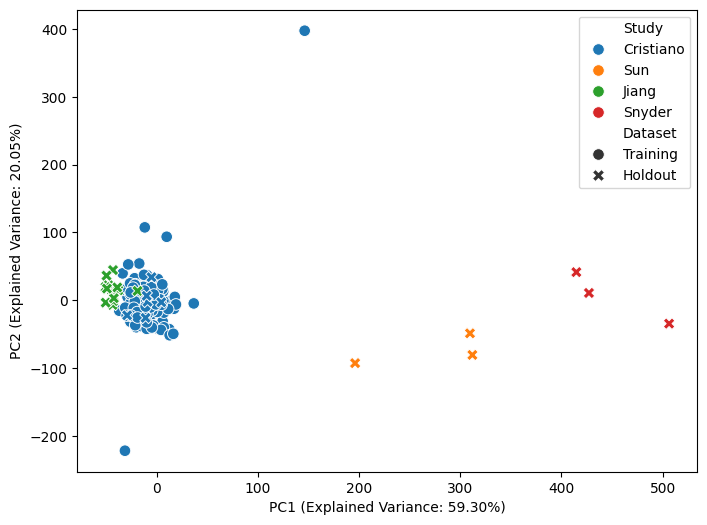

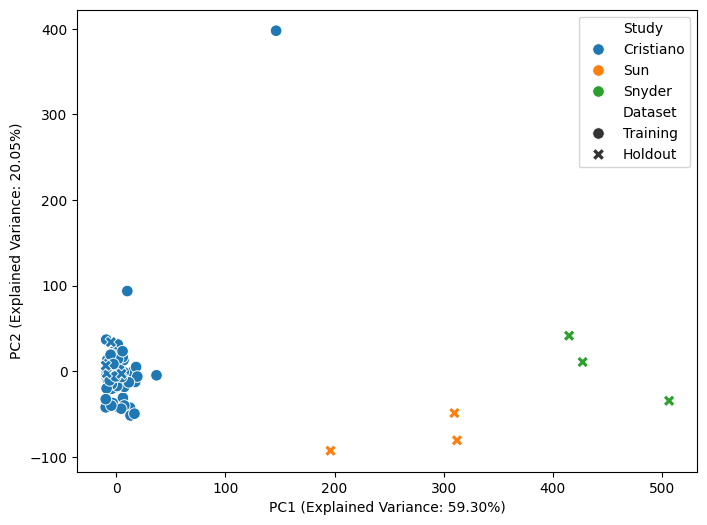

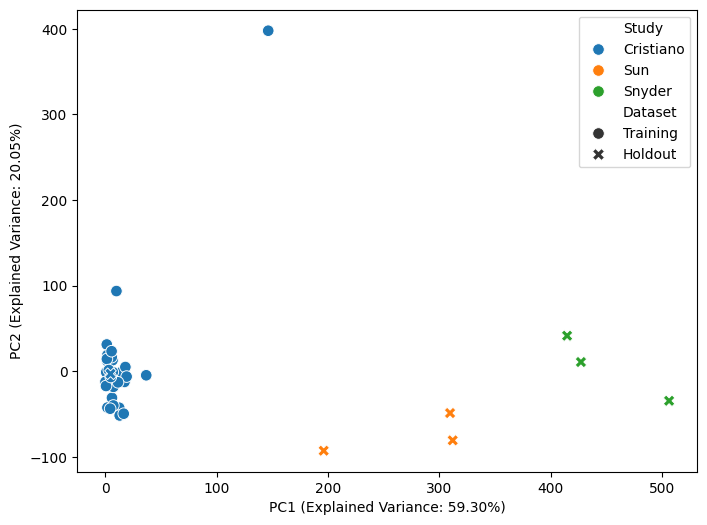

,PC1,PC2,Patient Type,Study,Dataset
sample,,,,,
EE86244,506.440692,-34.502410,Pancreatic Cancer,Snyder,Holdout
EE86247,427.250299,10.755025,Pancreatic Cancer,Snyder,Holdout
EE86248,414.828034,41.490518,Pancreatic Cancer,Snyder,Holdout
EE85723,312.096227,-80.705293,Colorectal Cancer,Sun,Holdout
EE85724,309.714468,-48.840359,Colorectal Cancer,Sun,Holdout


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

TRAIN_MATRIX_PATH = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv"
CLINICAL_PATH = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
df_train_raw = pd.read_csv(TRAIN_MATRIX_PATH, sep="\t")
clinical_df_raw = pd.read_csv(CLINICAL_PATH, sep=";")
# 1. Metadaten vorbereiten (AgeGroup für Stratifizierung)
# Wir berechnen den Median nur auf Basis der Fälle (wie in Skript 04)
median_age = clinical_df_raw[clinical_df_raw["Patient Type"].str.lower() != "healthy"]["Age at Diagnosis"].median()
clinical_df_raw["AgeGroup"] = pd.cut(
    clinical_df_raw["Age at Diagnosis"], 
    bins=[0, median_age-1, 120], 
    labels=[f"<{median_age}", f"{median_age}+"]
)
# 2. Filtern & Balancing (exakt wie in Skript 04)
# Wichtig: Falls du nach "Gender+Age" stratifizierst, müssen NaN-Werte raus
if STRATIFY_BY == "Gender+Age":
    clinical_df_filtered = clinical_df_raw[clinical_df_raw["Age at Diagnosis"].notna() & clinical_df_raw["Gender"].notna()].copy()
else:
    clinical_df_filtered = clinical_df_raw.copy()
cancer_df = clinical_df_filtered[clinical_df_filtered["Patient Type"].str.lower() != "healthy"]
healthy_df = clinical_df_filtered[clinical_df_filtered["Patient Type"].str.lower() == "healthy"]
# Balancing
healthy_balanced = healthy_df.sample(n=len(cancer_df), random_state=42)
clinical_train_balanced = pd.concat([cancer_df, healthy_balanced])
# --- WICHTIGER SCHRITT ZUM BEHEBEN DES KEYERRORS ---
# Wir behalten in der Matrix nur die Proben, die auch im klinischen DF sind
valid_ids = clinical_train_balanced["Extracted_ID"].unique()
df_train_filtered = df_train_raw[df_train_raw["sample"].isin(valid_ids)].copy()
# 3. Preprocessing aufrufen um X_train (80%) zu erhalten
from helper_functions import preprocess_data
X_train, _, y_train, _ = preprocess_data(df_train_filtered, clinical_train_balanced, STRATIFY_BY, needed_metrics)
print(f"Training Proben erfolgreich geladen: {X_train.shape[0]}")

# Markierung hinzufügen, was Training und was Holdout ist
X_train['Dataset'] = 'Training'
X_holdout['Dataset'] = 'Holdout'

# Metadaten für Training holen (Study Info ist in clinical_df_raw)
train_meta = clinical_df_raw.set_index('Extracted_ID').loc[X_train.index, ['Patient Type', 'Study']]
train_meta['Dataset'] = 'Training'

df_holdout_meta = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/study_matrix_holdout.csv", sep=";")
# Metadaten für Holdout (hast du schon aus study_matrix_holdout.csv)
df_holdout_meta = df_holdout_meta.set_index('Extracted_ID')

holdout_meta = df_holdout_meta.loc[X_holdout.index, ['Patient Type', 'Study']]
holdout_meta['Dataset'] = 'Holdout'

# Alles mergen
X_combined = pd.concat([X_train.drop(columns='Dataset'), X_holdout.drop(columns='Dataset')])
meta_combined = pd.concat([train_meta, holdout_meta])

# PCA berechnen
X_combined_scaled = StandardScaler().fit_transform(X_combined.fillna(0))
pca = PCA(n_components=2)
coords = pca.fit_transform(X_combined_scaled)

df_pca = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=X_combined.index)
df_pca = pd.concat([df_pca, meta_combined], axis=1)
study_colors = {
    "Cristiano": "#1f77b4",
    "Sun":       "#ff7f0e",
    "Snyder":    "#2ca02c",
    "Jiang":     "#d62728",
}
# Plot
plt.figure(figsize=(12, 8))
available_studies = [s for s in study_colors.keys() if s in df_pca['Study'].unique()]
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='Study', 
    style='Dataset',        # Training = Kreis, Holdout = (meist) Kreuz
    palette=study_colors,   # Hier werden die festen Farben zugewiesen
    hue_order=available_studies,
    s=120,                  # Größe der Punkte
    alpha=0.8,              # Leichte Transparenz für Überlappungen
    edgecolor='w'           # Weißer Rand für bessere Sichtbarkeit
)
plt.title("PCA: Training vs. Holdout (Colored by Study)")
plt.savefig("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/pca_studies_holdout_training.png")
plt.show()
# Zeige die 5 extremsten Proben auf PC1 an
print("The 5 most extreme samples on PC1:")
display(df_pca.sort_values(by='PC1', key=abs, ascending=False).head(5))

filtered_values = [-300, -10, 0]
for value in filtered_values:
    filtered = df_pca[df_pca["PC1"] > value]
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=filtered,
                x="PC1", y="PC2",
                hue="Study",
                style="Dataset",
                s=70)
    plt.xlabel(f"PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})")
    plt.ylabel(f"PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})")
    plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/pca_studies_holdout_training_{value}.png")
    plt.show()

display(filtered.sort_values(by="PC1", key=abs, ascending=False).head(5))


/tmp/ipykernel_1964108/3873832289.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_1964108/3873832289.py:44: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


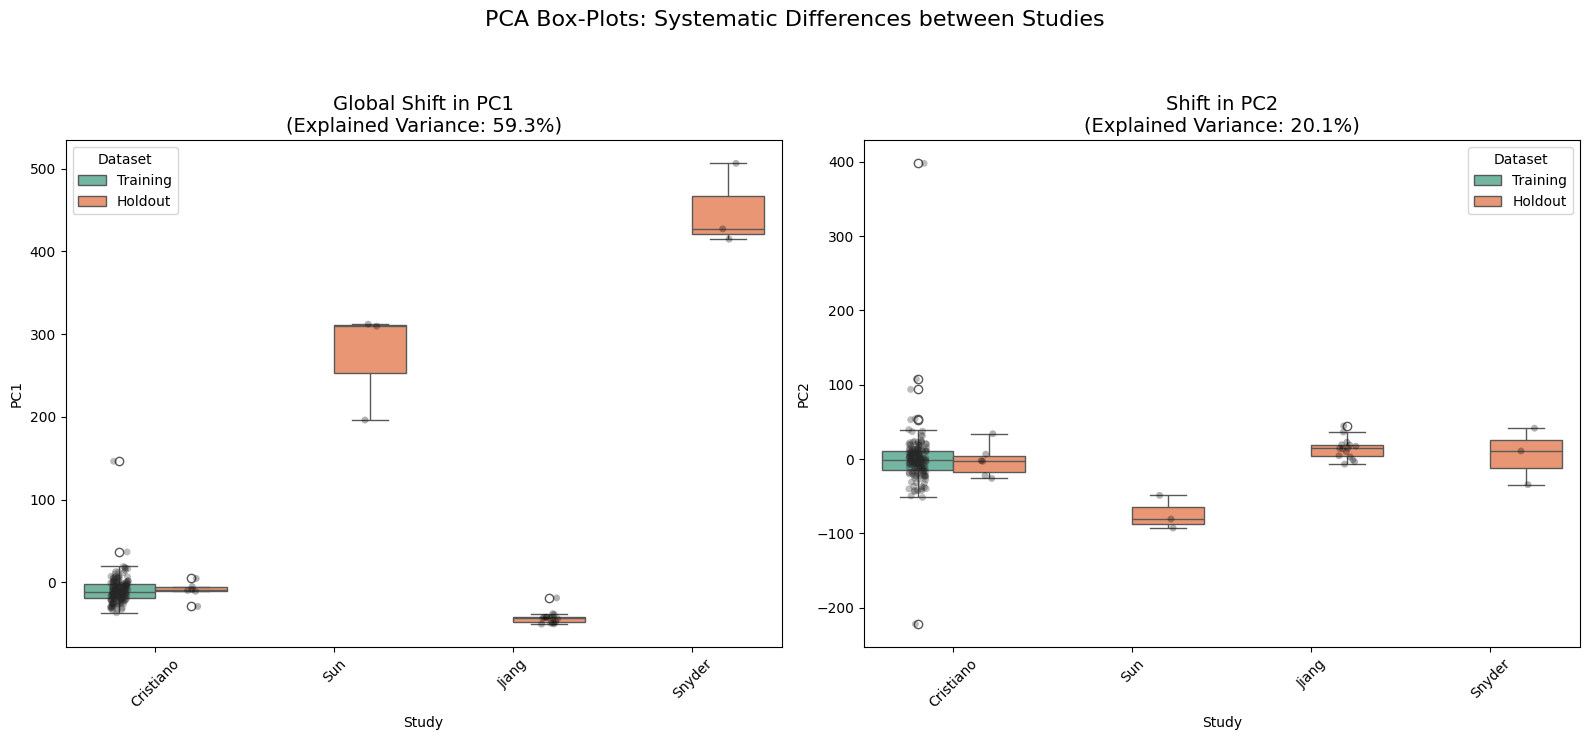

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wir nutzen das df_pca (oder df_pca_plot), um die Verteilungen zu vergleichen
# Falls du Ausreißer filtern willst, nimm df_pca_plot
plot_df = df_pca.copy()

# Wir erstellen ein Layout mit zwei Plots nebeneinander (PC1 und PC2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

# --- Plot 1: PC1 Verteilung nach Studie ---
# PC1 zeigt meistens den Batch-Effekt
sns.boxplot(
    data=plot_df, 
    x='Study', 
    y='PC1', 
    hue='Dataset',
    palette='Set2', 
    ax=ax1
)
sns.stripplot(
    data=plot_df, 
    x='Study', 
    y='PC1', 
    hue='Dataset', 
    dodge=True, 
    color='black', 
    alpha=0.3, 
    ax=ax1,
    legend=False
)
ax1.set_title(f"Global Shift in PC1\n(Explained Variance: {pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: PC2 Verteilung nach Studie ---
sns.boxplot(
    data=plot_df, 
    x='Study', 
    y='PC2', 
    hue='Dataset', 
    palette='Set2', 
    ax=ax2
)
sns.stripplot(
    data=plot_df, 
    x='Study', 
    y='PC2', 
    hue='Dataset', 
    dodge=True, 
    color='black', 
    alpha=0.3, 
    ax=ax2,
    legend=False
)
ax2.set_title(f"Shift in PC2\n(Explained Variance: {pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("PCA Box-Plots: Systematic Differences between Studies", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/boxplot_batch_effect.png")
plt.show()


In [20]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout[model_features])[:, 1]

Running prediction on 27 samples...


In [21]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


FINAL HOLDOUT AUC: 0.4111



In [22]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


Detailed results and plots saved in 'holdout_preprocessing/'.


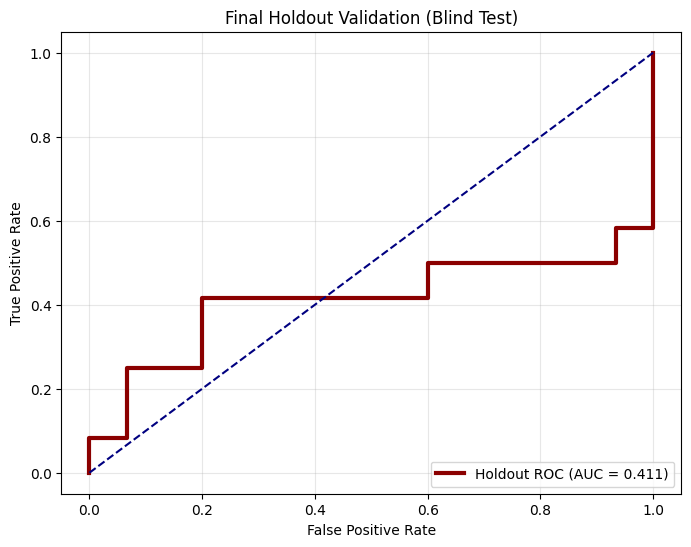

In [23]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")

In [24]:
# 5.5 DIAGNOSTIC: Check what's happening
print("="*80)
print("DIAGNOSTIC: Label & Prediction Analysis")
print("="*80)

preds = (probs > 0.5).astype(int)

print(f"\n1. Label Distribution:")
print(f"   0 (Healthy): {np.sum(y_holdout == 0)} samples")
print(f"   1 (Cancer):  {np.sum(y_holdout == 1)} samples")

print(f"\n2. Prediction Distribution:")
print(f"   0 (Predicted Healthy): {np.sum(preds == 0)} samples")
print(f"   1 (Predicted Cancer):  {np.sum(preds == 1)} samples")

print(f"\n3. Probability Statistics:")
print(f"   Min:    {probs.min():.4f}")
print(f"   Max:    {probs.max():.4f}")
print(f"   Mean:   {probs.mean():.4f}")
print(f"   Median: {np.median(probs):.4f}")

tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(f"\n4. Confusion Matrix:")
print(f"   TP: {tp:2d}  FP: {fp:2d}")
print(f"   FN: {fn:2d}  TN: {tn:2d}")

print(f"\n5. Sample-by-Sample Breakdown:")
results_diag = pd.DataFrame({
    'sample': X_holdout.index,
    'group': group_info.loc[X_holdout.index, 'group'].values,
    'true_label': y_holdout,
    'prob_cancer': probs,
    'pred_label': preds
})
print(results_diag.sort_values('prob_cancer', ascending=False).to_string())

print(f"\n6. AUC Test - Check if labels are inverted:")
y_flipped = 1 - y_holdout
from sklearn.metrics import roc_auc_score
auc_flipped = roc_auc_score(y_flipped, probs)
print(f"   Current AUC:       {roc_auc_score(y_holdout, probs):.4f}")
print(f"   AUC with flipped labels: {auc_flipped:.4f}")
if auc_flipped > 0.8:
    print(f"   ⚠️  ALERT: Labels might be INVERTED! AUC improves to {auc_flipped:.4f}")

print("="*80)

DIAGNOSTIC: Label & Prediction Analysis

1. Label Distribution:
   0 (Healthy): 15 samples
   1 (Cancer):  12 samples

2. Prediction Distribution:
   0 (Predicted Healthy): 18 samples
   1 (Predicted Cancer):  9 samples

3. Probability Statistics:
   Min:    0.0000
   Max:    0.9990
   Mean:   0.3903
   Median: 0.2996

4. Confusion Matrix:
   TP:  5  FP:  4
   FN:  7  TN: 11

5. Sample-by-Sample Breakdown:
     sample       group  true_label   prob_cancer  pred_label
2   EE85726  colorectal           1  9.989857e-01           1
13  EE85842     healthy           0  9.691521e-01           1
22  EE87787    bileduct           1  9.524764e-01           1
21  EE87786    bileduct           1  9.386538e-01           1
7   EE85784     healthy           0  9.356056e-01           1
10  EE85795     healthy           0  9.036648e-01           1
23  EE87788    bileduct           1  5.786566e-01           1
24  EE87893     gastric           1  5.629582e-01           1
4   EE85757     healthy         

In [25]:
df_holdout[df_holdout["group"] =="pancreatic"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
76680,EE86244,pancreatic,chr1,18,115.917540,98.572760,47.462974,42.126549,181.470073,-0.510411,900000,950000,0.63236,chr1_900000
76681,EE86244,pancreatic,chr1,21,116.774404,99.618293,65.990639,38.105430,306.004381,-0.200328,1050000,1100000,0.62400,chr1_1050000
76682,EE86244,pancreatic,chr1,23,116.398701,109.618210,54.881767,44.692390,254.439142,-0.347350,1150000,1200000,0.59202,chr1_1150000
76683,EE86244,pancreatic,chr1,25,126.707891,142.402685,50.977465,32.045817,241.612680,-0.470818,1250000,1300000,0.60030,chr1_1250000
76684,EE86244,pancreatic,chr1,26,113.081272,111.115359,52.126409,38.493717,258.527309,-0.360830,1300000,1350000,0.64590,chr1_1300000
76685,EE86244,pancreatic,chr1,27,98.467783,91.629054,44.116532,38.969522,206.557757,-0.256151,1350000,1400000,0.56750,chr1_1350000
76686,EE86244,pancreatic,chr1,28,109.457122,94.625128,52.535289,39.979076,222.333913,-0.307723,1400000,1450000,0.57180,chr1_1400000
76687,EE86244,pancreatic,chr1,30,110.943408,99.912470,56.786951,34.024910,253.084812,-0.189870,1500000,1550000,0.59168,chr1_1500000
76688,EE86244,pancreatic,chr1,32,133.262063,146.059228,55.517271,35.059995,299.957351,-0.538920,1600000,1650000,0.60602,chr1_1600000
76689,EE86244,pancreatic,chr1,33,142.101939,159.724126,44.837255,45.875814,200.955934,-0.379836,1650000,1700000,0.52990,chr1_1650000


In [26]:
df_holdout[df_holdout["group"] =="gastric"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
115020,EE87893,gastric,chr1,18,161.573213,165.361049,23.345738,114.532721,230.420516,-0.008256,900000,950000,0.63236,chr1_900000
115021,EE87893,gastric,chr1,21,175.726416,172.772317,14.624693,151.674910,230.085779,0.149016,1050000,1100000,0.62400,chr1_1050000
115022,EE87893,gastric,chr1,23,166.962339,167.259091,16.194709,132.886289,206.104729,-0.213177,1150000,1200000,0.59202,chr1_1150000
115023,EE87893,gastric,chr1,25,170.710694,167.266540,19.469610,125.578608,226.615589,-0.447595,1250000,1300000,0.60030,chr1_1250000
115024,EE87893,gastric,chr1,26,167.719953,165.003636,16.883603,124.970099,211.285545,0.114930,1300000,1350000,0.64590,chr1_1300000
115025,EE87893,gastric,chr1,27,167.222737,168.155978,22.605078,108.636895,243.748981,-0.165592,1350000,1400000,0.56750,chr1_1350000
115026,EE87893,gastric,chr1,28,166.371864,163.703170,22.959345,110.063914,215.928150,0.038312,1400000,1450000,0.57180,chr1_1400000
115027,EE87893,gastric,chr1,30,164.480707,157.422020,20.340588,128.225414,206.757232,-0.259349,1500000,1550000,0.59168,chr1_1500000
115028,EE87893,gastric,chr1,32,161.917831,160.578892,16.863975,120.981187,202.352111,-0.161908,1600000,1650000,0.60602,chr1_1600000
115029,EE87893,gastric,chr1,33,151.167035,151.751750,21.275967,102.265583,191.147557,-0.682243,1650000,1700000,0.52990,chr1_1650000


In [27]:
df_holdout[df_holdout["group"] =="colorectal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
0,EE85723,colorectal,chr1,18,121.873988,84.653969,43.064116,27.104385,173.173973,-0.454357,900000,950000,0.63236,chr1_900000
1,EE85723,colorectal,chr1,21,123.076178,130.803106,9.496587,75.722503,141.645610,-0.346448,1050000,1100000,0.62400,chr1_1050000
2,EE85723,colorectal,chr1,23,106.530763,116.875511,28.045713,28.201923,147.211087,-0.410098,1150000,1200000,0.59202,chr1_1150000
3,EE85723,colorectal,chr1,25,131.500618,138.138259,13.874622,83.785539,153.361461,-0.344989,1250000,1300000,0.60030,chr1_1250000
4,EE85723,colorectal,chr1,26,104.961001,111.367002,17.675930,45.812068,137.337808,-0.462196,1300000,1350000,0.64590,chr1_1300000
5,EE85723,colorectal,chr1,27,116.360314,121.523693,73.653040,14.531443,196.506616,-0.267057,1350000,1400000,0.56750,chr1_1350000
6,EE85723,colorectal,chr1,28,119.692241,115.467310,43.787627,21.215207,179.271765,-0.466075,1400000,1450000,0.57180,chr1_1400000
7,EE85723,colorectal,chr1,30,135.594707,127.507399,18.049147,81.933475,162.816935,-0.371662,1500000,1550000,0.59168,chr1_1500000
8,EE85723,colorectal,chr1,32,152.072744,145.971864,17.270324,96.188341,175.389893,-0.441496,1600000,1650000,0.60602,chr1_1600000
9,EE85723,colorectal,chr1,33,100.641251,85.121112,44.999032,3.708448,150.845374,-0.240760,1650000,1700000,0.52990,chr1_1650000


In [28]:
print(df_holdout[["mean", "median", "stdev", "min", "max", "wps_value"]].mean())


mean         158.237461
median       158.046721
stdev         23.548761
min          106.141608
max          220.443550
wps_value     -0.226475
dtype: float64


In [29]:
df_holdout[df_holdout["group"] =="esophageal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id


In [30]:
# --- FEATURE TREND ANALYSIS (In dein Validierungs-Skript einfügen) ---
print("\n" + "="*60)
print("FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout")
print("="*60)

# 1. Hol dir die Koeffizienten und den Scaler aus der geladenen Pipeline
scaler = model.named_steps['scaler']
stable_model = model.named_steps['stable_model']
coeffs = stable_model.coef_[0]

# 2. Finde die Top 5 Features (stärkste Auswirkung auf die Entscheidung)
top_indices = np.argsort(np.abs(coeffs))[::-1][:5]
top_features = [model_features[i] for i in top_indices]

comparison_results = []

for idx in top_indices:
    feat_name = model_features[idx]
    
    # Trainings-Info: Der Scaler "weiß" noch den Mittelwert aus dem Training
    train_mean = scaler.mean_[idx]
    train_coeff = coeffs[idx]
    
    # Holdout-Info: Tatsächliche Werte in deinem aktuellen Datensatz
    h_healthy = X_holdout.loc[y_holdout == 0, feat_name].mean()
    h_cancer = X_holdout.loc[y_holdout == 1, feat_name].mean()
    h_trend = h_cancer - h_healthy  # Positiv, wenn Cancer > Healthy
    
    comparison_results.append({
        'Feature': feat_name,
        'Coeff (Train)': train_coeff,
        'Train_Mean_Total': train_mean,
        'Holdout_Healthy': h_healthy,
        'Holdout_Cancer': h_cancer,
        'Holdout_Trend': h_trend
    })

df_trends = pd.DataFrame(comparison_results)
print(df_trends.to_string(index=False))

# 3. Logik-Check für die Inversion
print("\n--- INVERSION CHECK ---")
for _, row in df_trends.iterrows():
    # Wenn Coeff > 0, erwartet das Modell: Cancer > Healthy
    # Wenn Coeff < 0, erwartet das Modell: Cancer < Healthy
    expected_positive_trend = row['Coeff (Train)'] > 0
    actual_positive_trend = row['Holdout_Trend'] > 0
    
    if expected_positive_trend != actual_positive_trend:
        print(f"⚠️  INVERSION in {row['Feature']}:")
        print(f"   Model expects {'INCREASE' if expected_positive_trend else 'DECREASE'} for Cancer.")
        print(f"   Data shows {'INCREASE' if actual_positive_trend else 'DECREASE'} in Holdout.")
    else:
        print(f"✅ Trend for {row['Feature']} is consistent with training logic.")
        


FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout
             Feature  Coeff (Train)  Train_Mean_Total  Holdout_Healthy  Holdout_Cancer  Holdout_Trend
  mean_chr6_52050000      -0.560614        167.917697       172.039916      149.698375     -22.341541
stdev_chr1_144150000      -0.552454         -1.037950        -1.018305       -1.220597      -0.202292
 mean_chr17_40800000      -0.513130        165.007040       168.917381      146.990766     -21.926615
  stdev_chr11_400000      -0.509139         18.436999        17.948470       27.480984       9.532514
 mean_chr1_158450000      -0.471403        165.796431       171.590827      147.602005     -23.988822

--- INVERSION CHECK ---
✅ Trend for mean_chr6_52050000 is consistent with training logic.
✅ Trend for stdev_chr1_144150000 is consistent with training logic.
✅ Trend for mean_chr17_40800000 is consistent with training logic.
⚠️  INVERSION in stdev_chr11_400000:
   Model expects DECREASE for Cancer.
   Data shows INCREASE in H

In [31]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# 1. Studien-Informationen laden
study_info_path = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/study_matrix_holdout.csv"
df_study = pd.read_csv(study_info_path, sep=";")
df_study = df_study.set_index('Extracted_ID')

# 2. DataFrame für die Analyse bauen
# Wir stellen sicher, dass die Indizes (Sample IDs) übereinstimmen
analysis_df = pd.DataFrame({
    'sample': X_holdout.index,
    'true_label': y_holdout,
    'prob_cancer': probs
}).set_index('sample')

# Studie hinzufügen
analysis_df['study'] = df_study.loc[analysis_df.index, 'Study']

print("=== AUC-Analyse pro Studie (Holdout) ===")
print("-" * 50)

for study, data in analysis_df.groupby('study'):
    n_total = len(data)
    n_healthy = sum(data['true_label'] == 0)
    n_cancer = sum(data['true_label'] == 1)
    
    if n_healthy > 0 and n_cancer > 0:
        auc = roc_auc_score(data['true_label'], data['prob_cancer'])
        print(f"Studie: {study:12} | AUC: {auc:.4f} | n={n_total} (H:{n_healthy}, C:{n_cancer})")
    else:
        # In Jiang sind z.B. nur Healthy Proben, da kann man keinen AUC berechnen
        avg_prob = data['prob_cancer'].mean()
        print(f"Studie: {study:12} | AUC: N/A (nur 1 Klasse) | n={n_total} | Avg Prob: {avg_prob:.2e}")

print("-" * 50)
print("\n=== Vergleich der Durchschnitts-Scores ===")
# Hier sehen wir, ob eine Studie generell viel höhere/niedrigere Scores liefert als andere
study_summary = analysis_df.groupby(['study', 'true_label'])['prob_cancer'].mean().unstack()
study_summary.columns = ['Mean Prob (Healthy)', 'Mean Prob (Cancer)']
print(study_summary)


=== AUC-Analyse pro Studie (Holdout) ===
--------------------------------------------------
Studie: Cristiano    | AUC: N/A (nur 1 Klasse) | n=6 | Avg Prob: 5.55e-01
Studie: Jiang        | AUC: N/A (nur 1 Klasse) | n=15 | Avg Prob: 4.10e-01
Studie: Snyder       | AUC: N/A (nur 1 Klasse) | n=3 | Avg Prob: 3.26e-07
Studie: Sun          | AUC: N/A (nur 1 Klasse) | n=3 | Avg Prob: 3.51e-01
--------------------------------------------------

=== Vergleich der Durchschnitts-Scores ===
           Mean Prob (Healthy)  Mean Prob (Cancer)
study                                             
Cristiano                  NaN        5.548037e-01
Jiang                 0.410448                 NaN
Snyder                     NaN        3.255361e-07
Sun                        NaN        3.511350e-01
